# Описание проекта.

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# Описание данных.

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы долларов)
* EU_sales — продажи в Европе (миллионы долларов)
* JP_sales — продажи в Японии (миллионы долларов)
* Other_sales — продажи в других странах (миллионы долларов)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

**Импортируем библиотеки.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats as st
import seaborn as sns

## Шаг 1. Ознакомление с данными.

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


*В первых 10 строках оченнь много пропусков. Это печально.*

**1.1. Общая информация о датафрейме.**

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


User_Score будем менять на float.

**1.2. Визуализация пропусков**

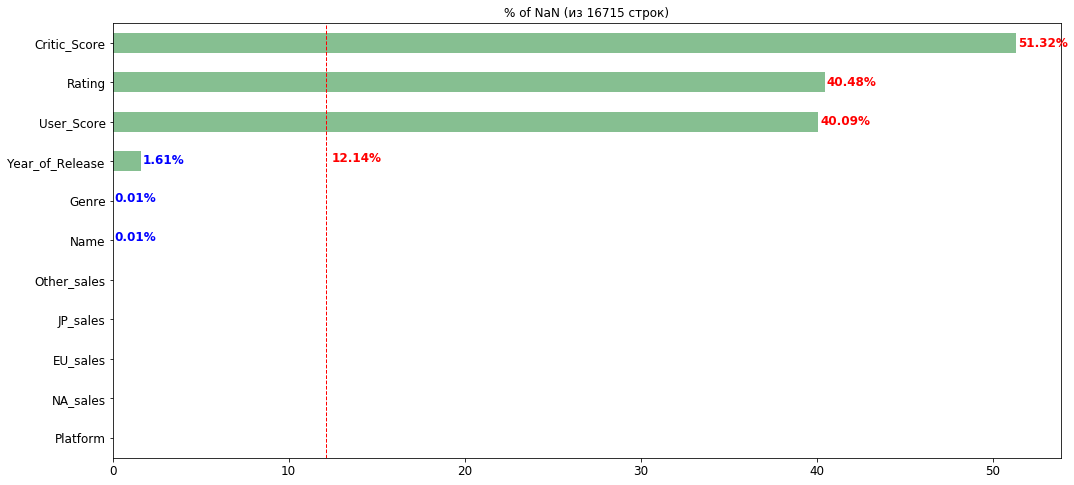

In [5]:
def percent_hbar(df, old_threshold=None):
    percent_of_nulls = (df.isnull().sum()/len(df)*100).sort_values().round(2)
    threshold = percent_of_nulls.mean()
    ax = percent_of_nulls.plot(kind='barh', figsize=(17, 8), title='% of NaN (из {} строк)'.format(len(df)), 
                               color='#86bf91', legend=False, fontsize=12)
    ax.set_xlabel('Count of NaN')
    dict_percent = dict(percent_of_nulls)
    i = 0
    for k in dict_percent:
        color = 'blue'
        if dict_percent[k] > 0:
            if dict_percent[k] > threshold:
                color = 'red'
            ax.text(dict_percent[k]+0.1, i + 0.09, str(dict_percent[k])+'%', color=color, 
                    fontweight='bold', fontsize='large')
        i += 0.98
    if old_threshold is not None:
        plt.axvline(x=old_threshold,linewidth=1, color='r', linestyle='--')
        ax.text(old_threshold+0.3, 10, '{0:.2%}'.format(old_threshold/100), color='r', fontweight='bold', fontsize='large')
        plt.axvline(x=threshold,linewidth=1, color='green', linestyle='--')
        ax.text(threshold+0.3, 7, '{0:.2%}'.format(threshold/100), color='green', fontweight='bold', fontsize='large')
    else:
        plt.axvline(x=threshold,linewidth=1, color='r', linestyle='--')
        ax.text(threshold+0.3, 7, '{0:.2%}'.format(threshold/100), color='r', fontweight='bold', fontsize='large')
    ax.set_xlabel('')
    return ax, threshold

plot, threshold = percent_hbar(games)

*critic_score - оценка критиков - вполне возможно, что игры не оценивались критиками, т.к. тогда не было такого "обычая". Было бы неправильно заполнить рейтинг игры средним или медианой, даже если бы мы их считали внутри для каждого жанра отдельно. Тем не менее, чтобы иметь возможность быстрой фильтрации данных и возможность их беспрепятственно обрабатывать, поставим этим играм рейтинг -1 (вдруг у какой-то игры есть нулевой рейтинг, поставив -1, мы никогда не перемешаем игры с NaN и с реально нулевым рейтингом);*
*rating - рейтинг от ESRB - может быть, в те времена не было такой организации, вот и рейтинга от неё тоже нет. Здесь то же самое. Невозможно дать рейтинг игре, посчитав его как среднее рейтингов игр того же жанра. Поставим рейтинг "No ESRB";
user_score - те же причины, вероятно, ранее не было сервисов, которые собирали бы рейтинги игроков. Поэтому и присутствуют пропуски. Поступим так же, как и со столбцом critic_score.*

Столбец year_of_release (год выпуска игры) имеет 1,6% пропусков. Не много, но неприятно. Средними/медианами эти пропуски не заполнить, эти данные не являются самыми важными для анализа данных, да и пропусков в столбце не так много. Другими словами, целых данных достаточно для анализа, поэтому оставляем как есть.

Ни по одному столбцу заполнить пропуски хотя бы усредненными данными не представляется возможным. Тем не менее, заполним их "нереальными" данными для возможности спокойно работать с этими строками по другим параметрам.

In [6]:
games.query('Critic_Score.isnull() & Rating.isnull() & User_Score.isnull()')

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Пропуски есть как по старым, так и по новым играм.

## Шаг 2. Подготовка данных.

**2.1. Приведем названия столбцов к нижнему регистру.**

In [7]:
games.columns = games.columns.str.lower()

In [8]:
games.columns.values[2] = 'year'

In [9]:
def platform_groupper(row):
    if row['platform'] in ['3DS', 'DS', 'Wii', 'WiiU', 'GC', 'N64', 'NES', 'SNES']:
        return 'Nintendo'
    elif row['platform'] in ['PS', 'PS2', 'PS3', 'PS4', 'PSV', 'PSP']:
        return 'PS'
    elif row['platform'] in ['X360', 'XB', 'XOne']:
        return 'XBox'
    elif row['platform'] in ['PC']:
        return 'PC'
    elif row['platform'] in ['GB', 'GBA']:
        return 'GameBoy'
    elif row['platform'] in ['2600']:
        return 'Atari'
    elif row['platform'] in ['GEN', 'SAT', 'DC']:
        return 'Sega'
    else:
        return 'other'

games['plat_group'] = games.apply(platform_groupper, axis = 1)

**2.2. Изменение типа данных по столбцу user_score.**

Посмотрим отдельно столбцы user_score - его формат 'object, что очень странно, ведь если бы там были только числа и NaN'ы, то формат был бы 'float':

In [10]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Помимо пропусков видим 'tbd'. Изучим:

In [11]:
games[games['user_score'] == 'tbd']

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,plat_group
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E,Nintendo
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+,PS
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T,Nintendo
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E,Nintendo
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E,GameBoy
...,...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E,GameBoy
16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E,Nintendo
16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E,Nintendo
16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E,Nintendo


Почти 2500 строк с таким значением.

Почитав FAQ Metacritic'a, найдем, что это аббревиатура от To Be Determined. Пишется тогда, когда игра имеет недостаточное количество отзывов (менее 4) для подсчета рейтинга пользователей и его публикации.
Предполагаю, что с таким можно столкнуться, когда анализируешь или малопопулярные игры, или игры, имеющие приоисхождение и, соответственно, аудиторию, большая часть игроков которых не разговаривает по-английски и не оставляет свои отзывы на таких мировых сайтах как Metacritic. Как пример можно привести японские игры и их аудиторию - не думаю, что много японских игроков заходят на Metacritic, чтобы написать отзыв на языке, которым они практически не владеют. Они оценивают свои игры на популярных в Японии ресурсах.

Но числовой тип столбца нам необходим. Т.к. 'tbd' фактически и является NaN, заменим и NaN, и 'tbd' на значение -1 и приведем значение столбца к числовому:

In [12]:
games['user_score'] = games['user_score'].replace('tbd', np.NaN)
games['user_score'] = games['user_score'].astype('float')

**2.3. Обработка пропусков.**

In [13]:
games['critic_score'] = games['critic_score'].fillna(-1)
games['user_score'] = games['user_score'].fillna(-1)

In [14]:
print('Количество пропусков в столбце critic_score - {}'.format(games['critic_score'].isnull().sum()))
print('Количество пропусков в столбце user_score - {}'.format(games['user_score'].isnull().sum()))

Количество пропусков в столбце critic_score - 0
Количество пропусков в столбце user_score - 0


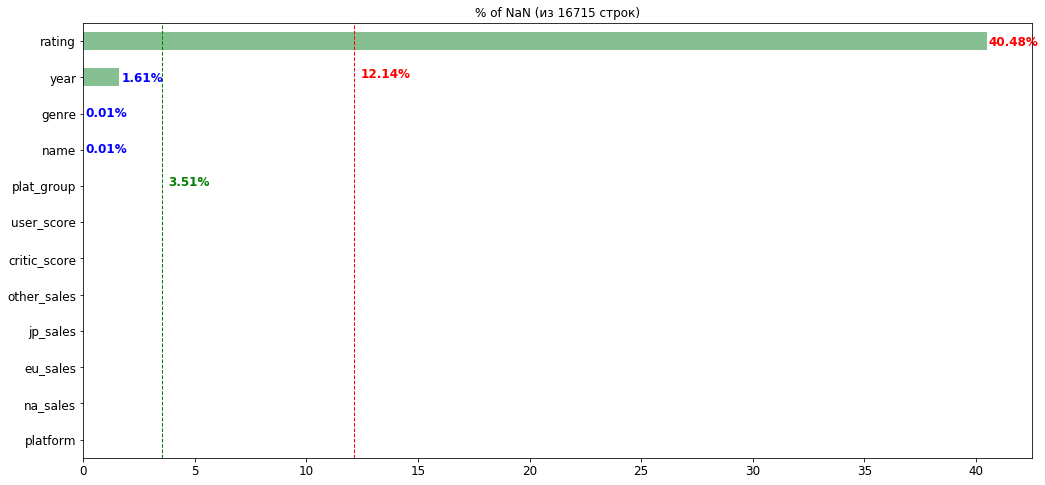

In [15]:
percent_hbar(games, threshold);

Уже лучше. Средний процент незаполненности составляет 4% вместо 12%.

**2.4. Отдельный столбец с суммой продаж по всем регионам.**

In [16]:
games['sales_total'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

## Шаг 3. Исследовательский анализ данных.

**3.1.Выбор актуального периода для анализа.**

Распределение продаж игр по платформам и группам платформ по годам:

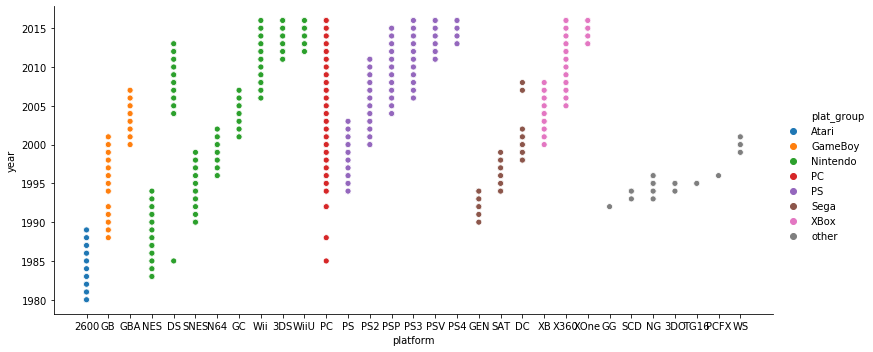

In [17]:
sns.relplot(x='platform', y='year', data=games.sort_values(by = ['plat_group', 'year']), 
                height =5, aspect = 2.2, hue = 'plat_group');

*Если не считать PC, который, естественно, является неизменной платформой, и прочие, не имевшие популярности, платформы, то видно, что средний срок жизни платформы равен примерно 10 годам. Это можно проверить численно:*

In [18]:
platforms = games.pivot_table(index = ['plat_group', 'platform'], values = 'year', aggfunc = ['min', 'max'])
platforms.columns = ['min', 'max']
platforms.reset_index(inplace=True)
platforms['lifespan'] = platforms['max'] - platforms['min']
platforms.sort_values(by='lifespan', ascending = False)

,plat_group,platform,min,max,lifespan
11,PC,PC,1985.0,2016.0,31.0
4,Nintendo,DS,1985.0,2013.0,28.0
1,GameBoy,GB,1988.0,2001.0,13.0
21,XBox,X360,2005.0,2016.0,11.0
16,PS,PSP,2004.0,2015.0,11.0
7,Nintendo,NES,1983.0,1994.0,11.0
13,PS,PS2,2000.0,2011.0,11.0
18,Sega,DC,1998.0,2008.0,10.0
14,PS,PS3,2006.0,2016.0,10.0
9,Nintendo,Wii,2006.0,2016.0,10.0


**3.2. Жизненный цикл платформ.**

Считаю медианную продолжительность жизни платформы, не учитывая ПК, прочие и платформы, выпущенные менее 10 лет назад, так как их жизненный цикл еще не закончен:

In [19]:
platforms.query('platform != "PC" and plat_group != "other" and min < 2007')['lifespan'].median()

9.5

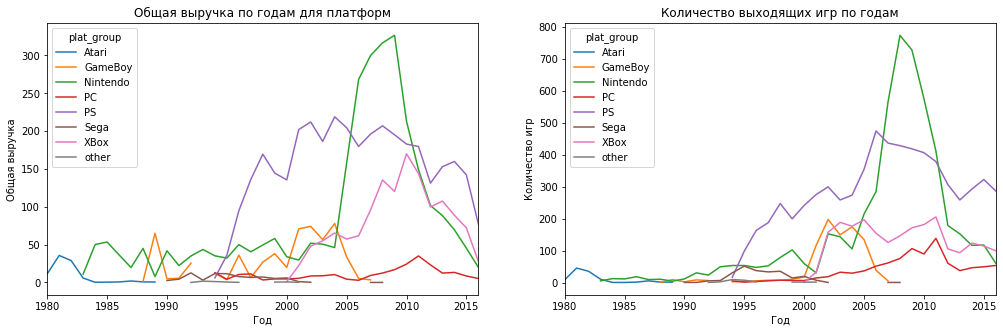

In [20]:
pivot_sum = games.pivot_table(index = 'year', columns = 'plat_group', values = 'sales_total', aggfunc = 'sum')
pivot_num = games.pivot_table(index = 'year', columns = 'plat_group', values = 'name', aggfunc = 'count')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (17,5))

pivot_sum.plot(kind = 'line', title ="Общая выручка по годам для платформ", ax=axes[0]).set(xlabel='Год', ylabel='Общая выручка')
pivot_num.plot(kind = 'line', title ="Количество выходящих игр по годам", ax=axes[1]).set(xlabel='Год', ylabel='Количество игр');

*Выводы по графикам:*
* Средняя продолжительность жизни одной платформы - 10 лет.
* В 2016 году продавались игры для 9 платформ 4 групп - ПК, PlayStation, Xbox и Nintendo.
* Последние игры для других платформ - Sega (DC) и GameBoy(GBA) были выпущены в 2007 и 2008 годах, на их закате.
* Максимальное количество продаж и по количеству, и по сумме достигнуто в 2008 году:

In [21]:
games.pivot_table(index = 'year', values = 'sales_total', aggfunc = ['count', 'sum']).idxmax()

count  sales_total    2008.0
sum    sales_total    2008.0
dtype: float64

* После 2008 года и количество, и объем продаж снизились примерно в 2,5 раза (без учета неполного 2016 года)

In [22]:
print(games[games['year'] == 2008]['sales_total'].sum() / games[games['year'] == 2015]['sales_total'].sum())
print(games[games['year'] == 2008]['name'].count() / games[games['year'] == 2015]['name'].count())

2.505784013732368
2.354785478547855


**Это могло произойти по разным причинам:**

* выход одной или нескольких сверхпопулярных игр конкретно в 2008 и соседние годы
* в целом индустрия игр на ПК и приставках снижается с 2008 года за счет кокуренции со стороны мобильных игр для смартфонов
* в целом индустрия игр на ПК и приставках снижается с 2008 года из-за финансового кризиса 2008 года и снижения покупательной способности населения
* продажи игр считаются накопительно за все годы и чем раньше появилась игра, тем больше у нее накапливается продаж со временем
* собранные данные неполные и не учитывают новые каналы продаж в последние годы

Чтобы проверить первую гипотезу, достаточно посмотреть список наиболее продаваемых игр за всю историю:

In [23]:
pivot = games.pivot_table(index = ['name', 'year'], values = 'sales_total', aggfunc = 'sum')
pivot.reset_index(inplace=True)
pivot.sort_values(by = 'sales_total', ascending = False).head(10)

,name,year,sales_total
11698,Wii Sports,2006.0,82.54
9906,Super Mario Bros.,1985.0,40.24
3966,Grand Theft Auto V,2013.0,37.32
5894,Mario Kart Wii,2008.0,35.52
11700,Wii Sports Resort,2009.0,32.77
7777,Pokemon Red/Pokemon Blue,1996.0,31.38
1329,Call of Duty: Modern Warfare 3,2011.0,30.60
10324,Tetris,1989.0,30.26
7119,New Super Mario Bros.,2006.0,29.80
1324,Call of Duty: Black Ops II,2012.0,29.40


Первая гипотеза не подтвердилась, в топ-10 только одна игра из 2008, значит, продажи в 2008 году больше за счет количества игр, а не отдельных хитов.
Проверяю вторую гипотезу - очевидно, что период снижения продаж на приставках совпал с ростом аудитории игр на смартфонах, однако неизвестно, является ли это единственной причиной. Добавляю столбец plat_type со значениями Pocket, Station(ary) и PC для мобильных и стационарных приставок и ПК и повторяю графики продаж только по этим группам:

In [24]:
def platform_type(row):
    if row['platform'] in ['PSP', 'PSV', 'WiiU', 'DS', 'GBA', '3DS', 'GB', '']:
        return 'Pocket'
    if row['platform'] in ['PC']:
        return 'PC'
    else:
        return 'Station'

games['plat_type'] = games.apply(platform_type, axis = 1)

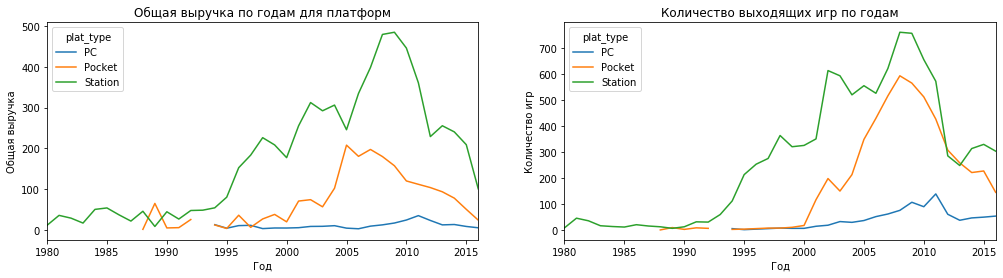

In [25]:
pivot_sum = games.pivot_table(index = 'year', columns = 'plat_type', values = 'sales_total', aggfunc = 'sum')
pivot_num = games.pivot_table(index = 'year', columns = 'plat_type', values = 'name', aggfunc = 'count')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (17,4))

pivot_sum.plot(kind = 'line', title ="Общая выручка по годам для платформ", ax=axes[0]).set(xlabel='Год', ylabel='Общая выручка')
pivot_num.plot(kind = 'line', title ="Количество выходящих игр по годам", ax=axes[1]).set(xlabel='Год', ylabel='Количество игр');

In [26]:
print('Год, доля продаж игр для портативных платформ:')
for year in games[games['year'] > 2007]['year'].sort_values().unique():
    print(year, games.query('plat_type == "Pocket" and year == @year')['sales_total'].sum() / games.query('year == @year')['sales_total'].sum())

Год, доля продаж игр для портативных платформ:
2008.0 0.2678481012658228
2009.0 0.23879056494945503
2010.0 0.20344669818514569
2011.0 0.2203199495646007
2012.0 0.2917322392086331
2013.0 0.2588030118480789
2014.0 0.23506168370886496
2015.0 0.18844689902231507
2016.0 0.18462367246421427


*Как видно на графиках и в таблице, доля портативных платформ начала снижаться только после 2013 года, то есть основное снижение с 2008 года происходило одинаково и для портативных, и для стационарных консолей. Если бы дело было в смартфонах, падение стационарных приставок было бы гораздо меньше.
Финансовый кризис абсолютно точно должен был повлиять на падение продаж игр, выпущенных после 2008 года: во-первых, геймеры могли позволить себе покупать меньше игр в целом, а во-вторых, покупать подешевшие игры предыдущих лет. Однако нет возможности проверить это численно или статистически и учесть это в анализе.*

In [27]:
pivot = games.query('year > 2003').pivot_table(index = 'year', values = 'sales_total', aggfunc = ('sum', 'count'))
pivot.columns = ['Количество', 'Выручка']
pivot['Средняя выручка'] = pivot['Выручка'] / pivot['Количество']
pivot['Средняя выручка'] = pivot['Средняя выручка'].round(2)
pivot

,Количество,Выручка,Средняя выручка
year,,,
2004.0,762,418.68,0.55
2005.0,939,457.82,0.49
2006.0,1006,517.71,0.51
2007.0,1197,604.75,0.51
2008.0,1427,671.50,0.47
2009.0,1426,658.82,0.46
2010.0,1255,590.13,0.47
2011.0,1136,507.58,0.45
2012.0,653,355.84,0.54


In [28]:
for i in range(10,13):
    decrease = (pivot.iloc[i,2] / pivot.iloc[9,2])
    print(round(decrease, 2))

0.86
0.67
0.39


*Как видно из средней выручки на 1 игру, этот показатель оставался стабильным в течение долгого периода и даже рос в 2011 - 2013 годах, однако начал снижаться в 2013-2015 годах. То есть эффект влияния покупок в течение нескольких лет после выхода игры вероятно присутствует (если не объясняется другими факторами) на сроке до 3-4 лет. Если исходить из примерно стабильной выручки с 2013 года, к концу года выхода игра в среднем собирает 39% выручки, за 2 года - 67%, за 3 - 86%, и наконец, за 4 года - полную выручку. Но этот эффект не объясняет снижение выручки в 2008-2012 гг., так как после этого прошло достаточно времени, чтобы его нивелировать.
Оставшуюся гипотезу (неполные данные) нельзя однозначно проверить на имеющихся данных, чтобы определить, какая доля изменений прихолится на эту причину, и какая - на прочие. Но для дальнейшего анализа они не имеют большой разницы с точки зрения влияния на прогноз выручки 2017 года. Важно то, что, по имеющимся у магазина данным, а значит, и каналам продаж, количество продаваемых игр и выручка снизились за последние 10 лет, хотя в последние годы это снижение прекратилось. Важно учитывать, что данные за 2016 год неполные, поэтому на абсолютные показатели 2016 года нужно смотреть осторожно.*

Гипотезы причины снижения продаж с 2008 года:

* выход одной или нескольких сверхпопулярных игр конкретно в 2008 и соседние годы - опровергнута
* в целом индустрия игр на ПК и приставках снижается с 2008 года за счет конкуренции со стороны мобильных игр для смартфонов - не подтвердилась
* в целом индустрия игр на ПК и приставках снижается с 2008 года из-за финансового кризиса 2008 года и снижения покупательной способности населения - эффект наверняка есть, однако невозможно оценить степень его влияния
* продажи игр считаются накопительно за все годы и чем раньше появилась игра, тем больше у нее накапливается продаж со временем - не подтвердилась, эффект присутсвует, однако на меньшем сроке
* собранные данные неполные и не учитывают новые каналы продаж в последние годы - невозможно подтвердить или опровергнуть

Учитывая снижение выручки более чем в два раза с 2008 года, строить тренды с этого периода неправильно. Платформы, появившиеся 10 лет назад, уже заканчивают свой жизненный цикл. Поэтому я беру данные за 5 лет, как половину от жизненного цикла платформы. Также можно оценить выручку платформ, чтобы отсечь неактуальные для цели анализа:

In [29]:
pivot = (games.query('year > 2011')
          .pivot_table(index = ['plat_group', 'plat_type', 'platform'], values = 'sales_total', aggfunc = 'sum')
          .sort_values(by = 'sales_total', ascending = False))
pivot.reset_index(inplace=True)
pivot

,plat_group,plat_type,platform,sales_total
0,PS,Station,PS4,314.14
1,PS,Station,PS3,288.79
2,XBox,Station,X360,236.54
3,Nintendo,Pocket,3DS,194.61
4,XBox,Station,XOne,159.32
5,Nintendo,Pocket,WiiU,82.19
6,PC,PC,PC,62.65
7,PS,Pocket,PSV,49.18
8,Nintendo,Station,Wii,35.37
9,Nintendo,Pocket,DS,12.55


Границу по выручке устанавливаю на уровне 30 миллионов долларов, чтобы отсечь 2 платформы, под которые, к тому же, уже не выпускается игр. Для дальнейшего анализа я оставляю только эти данные:

In [30]:
games5 = games.query('year > 2011 and platform != "DS" and platform != "PSP"')

Чтобы оценить тренды уже по очищенным данным, снова смотрю графики количества игр и продаж:

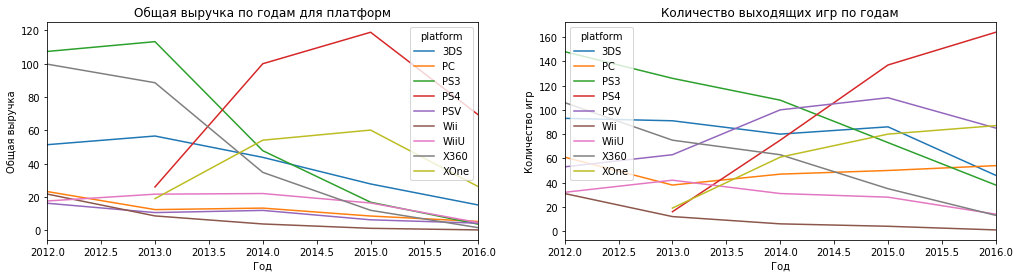

In [31]:
pivot_sum = games5.pivot_table(index = 'year', columns = 'platform', values = 'sales_total', aggfunc = 'sum')
pivot_num = games5.pivot_table(index = 'year', columns = 'platform', values = 'name', aggfunc = 'count')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (17,4))

pivot_sum.plot(kind = 'line', title = "Общая выручка по годам для платформ", ax=axes[0]).set(xlabel='Год', ylabel='Общая выручка')
pivot_num.plot(kind = 'line', title = "Количество выходящих игр по годам", ax=axes[1]).set(xlabel='Год', ylabel='Количество игр');

Основные тренды на этом горизонте:

* **понижающийся тренд с 2008 года выровнялся, однако в 2015 году (и неполном 2016) выручка значительно ниже, чем в 2014 при растущем количестве игр. Маловероятно, что стоимость игр снижается, поэтому это косвенно подтверждает то, что игры продолжают покупать в последующие после выпуска годы. Таким образом, можно считать, что рынок игр рос в 2013-2015 годах.**

In [32]:
games5.pivot_table(index = 'year', values = 'sales_total', aggfunc = ('sum', 'count'))

,count,sum
year,,
2012.0,524,337.14
2013.0,482,356.56
2014.0,571,331.29
2015.0,603,267.86
2016.0,502,129.94


* PS4 расчет за счет PS3 и лидирует и по выручке, и по количеству игр
* На втором месте - XBox One
* PSVita и ПК занимают 3 и 4 места и растут по количеству игр, но отстают по выручке, что говорит или о низкой средней выручке игр, или о неполных данных.

Среднюю выручку с игры можно увидеть через распределение:

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


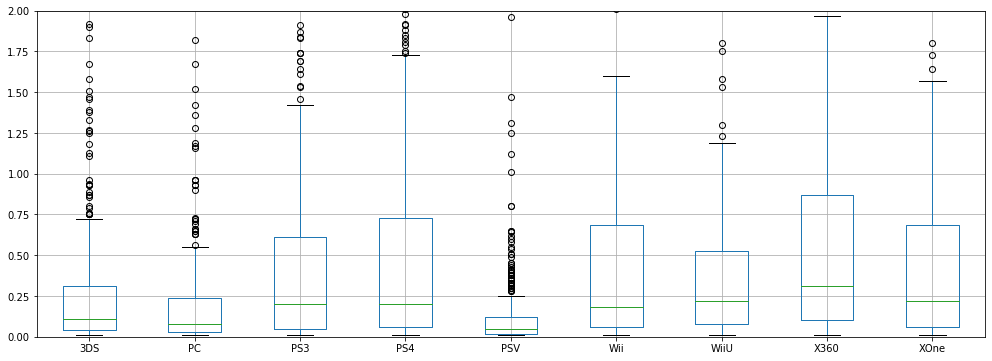

In [33]:
fig, ax = plt.subplots(figsize = (17,6))
games5.pivot_table(index = 'name', columns = 'platform', values = 'sales_total').boxplot(ax=ax, grid = True)
ax.set_ylim(0,2);

*На диаграмме рахмаха видно, что по стоимости лидируют главные стационарные консоли: X360, Wii, PS4. Интересно, что PS4 обгоняет предыдущую версию PS3, но XOne отстает от более старой X360. А среди портативных платформ выручка WiiU значительно выше PSVita. ПК и Nintendo в целом отстают от лидером по всем параметрам.*

**3.3. Влияние рейтингов на выручку платформ.**

Далее я проверяю влияние рейтингов на выручку игр. Для начала нужно понять, насколько коррелируют рейтинги критиков и пользователей на примере популярнейшей (ещё и самому интересно) платформы - PS3:

In [34]:
games_ps3 = games[(games['platform'] == 'PS3') & (games['critic_score'] > 0)].copy()

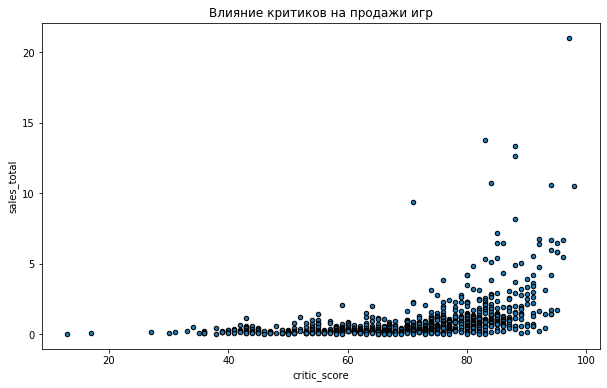

In [35]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

games_ps3 = games[(games['platform'] == 'PS3') & (games['critic_score'] > 0)].copy()
games_ps3.plot(kind='scatter', title = 'Влияние критиков на продажи игр', x='critic_score', y='sales_total', ec='black', figsize=(10,6));

С увеличением среднего рейтинга критиков увеличивается и средний уровень выручки с продажи игр, что логично: чем качественнее игра, тем больше денег она приносит разработчику и издателю.

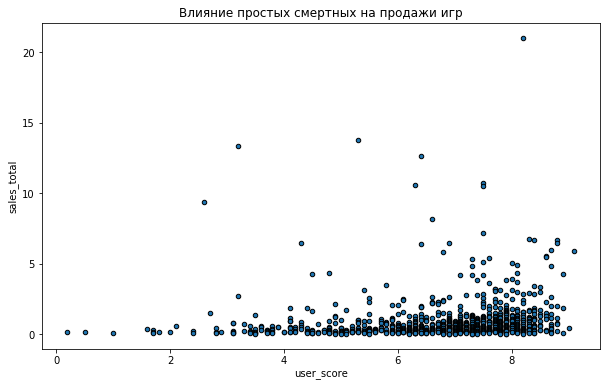

In [36]:
games_ps3 = games[(games['platform'] == 'PS3') & (games['user_score'] > 0)].copy()
games_ps3.plot(kind='scatter', title = 'Влияние простых смертных на продажи игр', x='user_score', y='sales_total', ec='black', figsize=(10,6));

Точно такая же картина, правда так называемых выбросов больше - когда рейтинг пользователей не велик, но тем не менее игра собирает большие деньги.

**Матрица корреляции:**

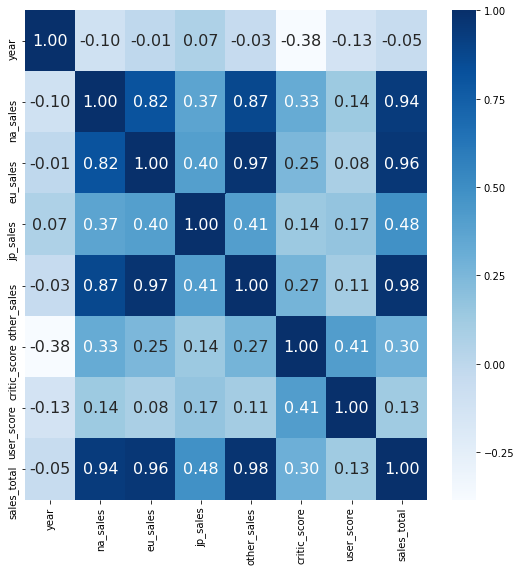

In [37]:
plt.figure(figsize=(9,9))
sns.heatmap(games_ps3.corr(), annot=True, cmap="Blues", fmt='.2f', annot_kws={'size':16});

In [38]:
games_ps3_filtered = games_ps3[['sales_total' ,'critic_score', 'user_score']]

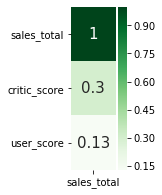

In [39]:
plt.figure(figsize=(1,3))
sns.heatmap(games_ps3_filtered.corr()[['sales_total']].sort_values(by='sales_total', ascending=False), cmap="Greens", 
            annot=True, annot_kws={'size':15})

Сильнее всего на конечную стоимость влияет оценка критиков, практически не влияет - оценка пользователей.

**Данные по корреляции по топовым платформам:**

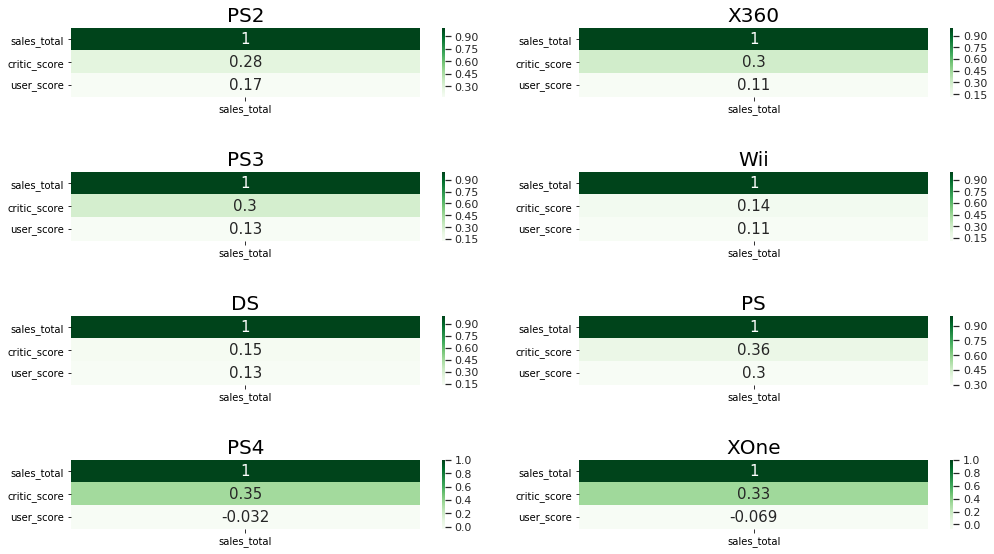

In [40]:
top_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'XOne']

rows = len(top_platforms) // 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(15,8.5))
count = 0
for r in range(rows):
    for c in range(cols):
        curr_platform = top_platforms[count]
        df_prep = games[(games['platform'] == curr_platform) & (games['user_score'] > 0)].copy()
        
        df_filtered = df_prep[['sales_total' ,'critic_score', 'user_score']]
        sns.set(font_scale=1.0)
        ax = sns.heatmap(df_filtered.corr()[['sales_total']].sort_values(by='sales_total', ascending=False), 
                         cmap="Greens", annot=True, annot_kws={'size':15}, ax=axes[r,c])
        ax.set_title(curr_platform, fontsize=20)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        plt.tight_layout(pad=3)
        count += 1

Данные по корреляции между выручкой и оценкой по платформам PS2, X360, PS3, PS и XOne более или менее совпадает с общими данными по датафрейму.
Выделяются Wii и DS, по которым зависимость не такая большая.
Кстати, есть платформы, где оценка критиков, согласно данных, сильнее "определяет" конечную выручку продукта, чем оценка пользователей. Это платформы DS, PS4 и Xone. В случае с DS полагаю, что дело в том, что приставка азиатская, большую популярность она имеет там, соответственно, далеко не большая часть игроков принимает участие в оценке игр на эту платформу. Про PS4 и Xone - платформы довольно новые, вполне вероятно, что пользователи пока не "освоились", поэтому большого количества отзывов, особенно качественных от них нет.

**3.4. Распределение игр по жанрам.**

Нарисуем столбчатую диаграмму с количеством и общей суммой продаж и расскажем о самых прибыльных жанрах, а потом посмотрим на особенности жанров с высокими и низкими продажами.

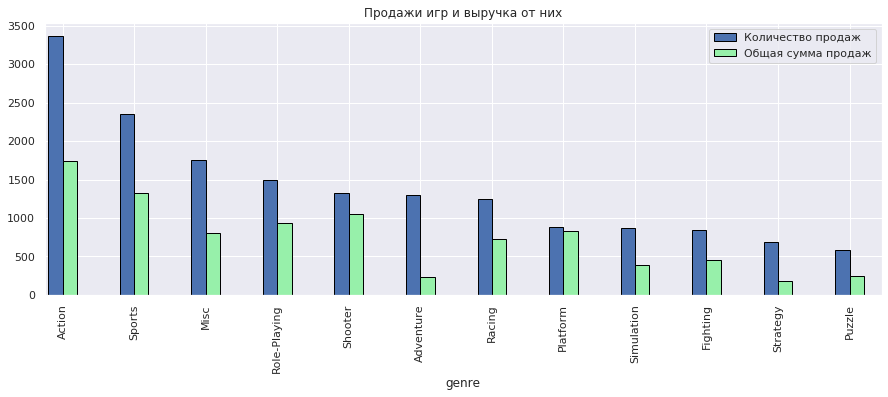

In [41]:
ax = plt.gca()

pivot = games.groupby('genre').agg({'name': 'count', 'sales_total': 'sum'}).sort_values(by='name', ascending=False)

plot1 = pivot['name']
plot1.plot(kind='bar', title = "Продажи игр и выручка от них", figsize=(15,5), ec='black', ax=ax, width=0.2, position=1)

plot2 = pivot['sales_total']
plot2.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, color='#97F0AA', position=0)

ax.legend(['Количество продаж', 'Общая сумма продаж']);

Больше всего игр жанра Action. За ними идут игры спортивного жанра. Причем даже учитывая то, что игр жанра "Спорт" заметно меньше на рынке (на треть от Action), выручка от продаж у них практически одинаковая. Это значит, что спортивные игры, в среднем, стоят дороже, чем шутеры. Ну и это ожидаемо, шутеры выходят преимущественно на ПК, тогда как спортивные игры - на консолях. А там явно и дела с пиратством лучше обстоят, да и сами лицензионные копии дороже.

# Шаг 4. Портрет пользователя регионов NA, EU, JP.

Определим для пользователя каждого региона (NA, EU, JP):

* самые популярные платформы (топ-5), опишем различия в долях продаж;
* самые популярные жанры (топ-5), поясним разницу;
* определим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

**4.1. Функция для прорисовки графиков top_in_regions_plot:**

In [42]:
def top_in_regions_plot(groupby, region_sales, ax):
    pivot = games.groupby(groupby).agg({region_sales: 'sum'}).sort_values(by=region_sales, ascending=False)[:5]
    title_dict = {'na_sales': 'North America Sales', 'eu_sales': 'Europe Sales', 'jp_sales': 'Japan Sales'}
    color_dict = {'na_sales': None, 'eu_sales': 'gray', 'jp_sales': 'forestgreen'}
    plot = pivot.plot(kind='bar', ec='black', title=title_dict[region_sales], ax=axes[ax], 
                   fontsize=18, color=color_dict[region_sales], rot=20)
    plot.legend(prop={'size':17})
    plot.set_xlabel('')
    plot.title.set_size(20)

**4.2. Определение самых популярных платформ в заданных регионах:**

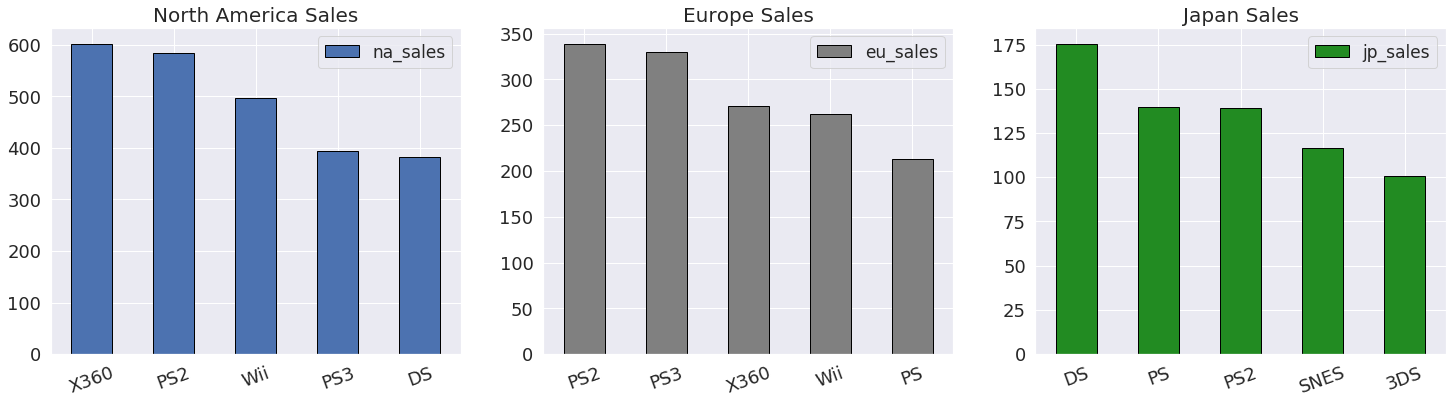

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot('platform', 'na_sales', 0)
top_in_regions_plot('platform', 'eu_sales', 1)
top_in_regions_plot('platform', 'jp_sales', 2)

* В Северной Америке имеют(имели) бешеную популярность приставки прошлого поколения X360 и PS2. Немного отстает Wii. Топ-4 и топ-5 - PS3 и DS соответственно.
* В Европе одинаково (были) популярны PS2 и PS3. За ними X360, Wii и PS.
* В Японии, как обычно, всё наоборот. Лидер - DS. За ними американские PS и PS2. Далее чисто японские SNES и 3DS.

**4.3. Определение самых популярных жанров в заданных регионах:**

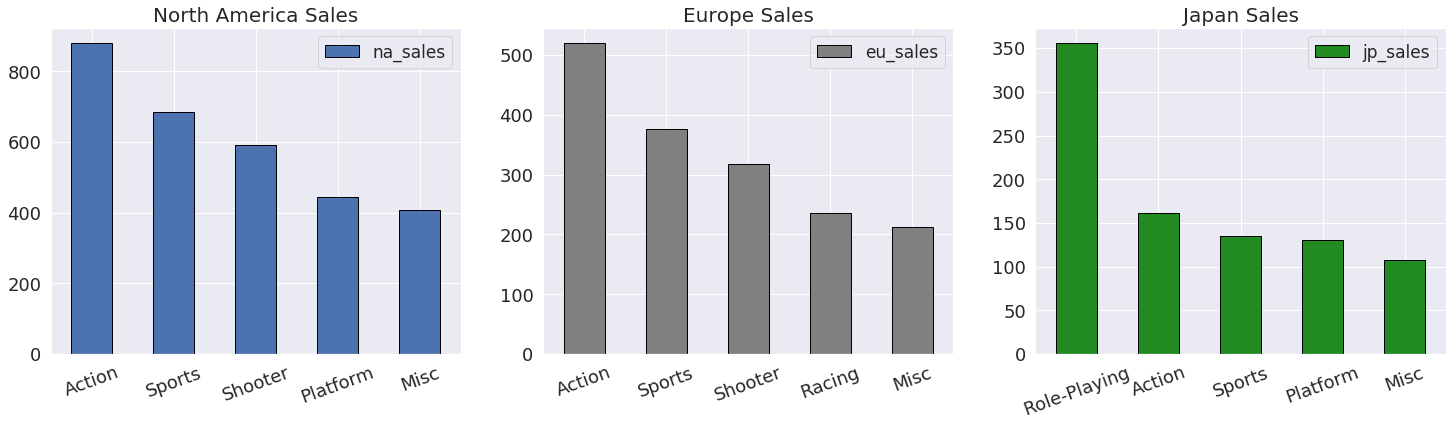

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot('genre', 'na_sales', 0)
top_in_regions_plot('genre', 'eu_sales', 1)
top_in_regions_plot('genre', 'jp_sales', 2)

* Вкусы в Северной Америке и Европе схожи: и там, и там живут фанаты экшнов, спортивных игр и шутеров. В Северной Америке больше играют в платформеры, в Европе же чаще выбирают гонки.
* В Японии вкус совершенно иной - на первом месте ролевые игры, причем с большим отрывом. Далее экшны и спортивные игры.

**4.4. Влияние рейтинга ESRB на продажи в отдельном регионе:**

Добавим новый столбец в основной датафрейм с разъяснением, какая буква рейтинга что означает:

In [45]:
ESRB_dict = {'E': 'Для всех', 'M': '> 17 лет', 'T': '13-19 лет', 'E10+': '>10 лет', 'K-A': 'Для всех(устар.)'}

In [46]:
games['ESRB_description'] = games[games['rating'].notnull()]['rating'].map(ESRB_dict)

Поглядим на продажи игр по рейтингу:

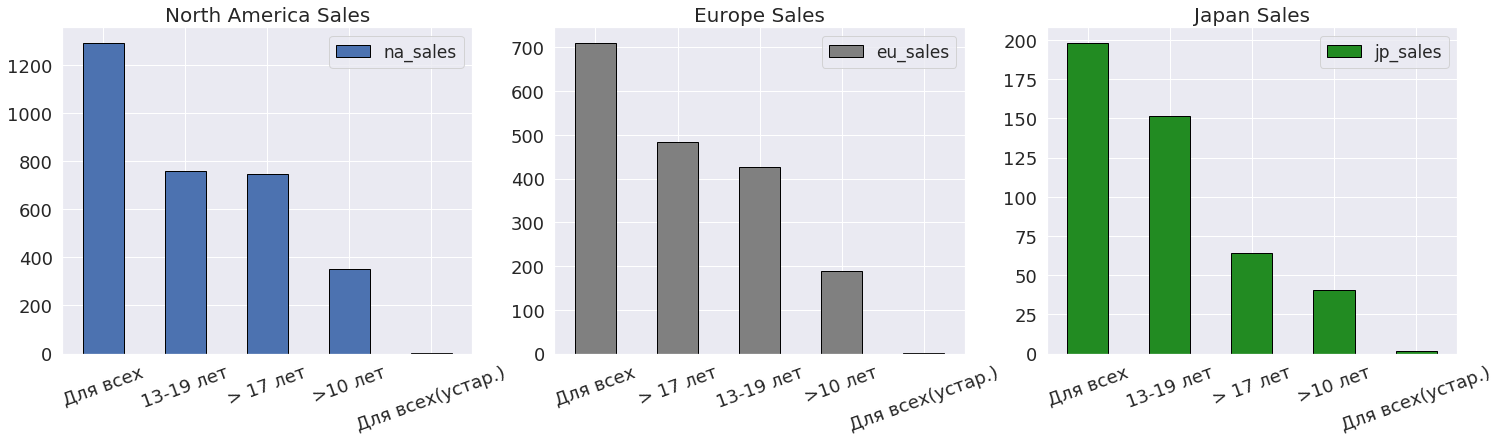

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot('ESRB_description', 'na_sales', 0)
top_in_regions_plot('ESRB_description', 'eu_sales', 1)
top_in_regions_plot('ESRB_description', 'jp_sales', 2)

* В Северной Америке и в Европе картина практически одинаковая. Большая часть выручки получено с игр с рейтингом "Для всех", поровну - с рейтингом "13-19 лет" и "для лиц старше 17 лет".
* В Японии опять не так. Первое место такое же - "Для всех", а вот на втором - игры для лиц от 13 до 19 лет. Да, там играют с раннего детства.

# Шаг 5. Проверка гипотез:

* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Экшн и Спорт разные.

**5.1. Гипотеза № 1:
средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**

Н0 (нулевая гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Н1 (альтернативная гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC отличаются между собой.

In [48]:
actual_platforms = games.query('year >= 2012')

In [49]:
xone = actual_platforms.query("platform == 'XOne' and user_score != -1")
pc = actual_platforms.query("platform == 'PC' and user_score != -1")

print("Дисперсия выборки xone",np.var(xone['user_score']))
print("Дисперсия выборки pc",np.var(pc['user_score']))

Дисперсия выборки xone 1.8965188383045526
Дисперсия выборки pc 2.7569952398906588


In [50]:
alpha = .05

results = st.ttest_ind(
    xone['user_score'],
    pc['user_score'],
    equal_var=False
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


In [51]:
xone['user_score'].mean()

6.521428571428572

In [52]:
pc['user_score'].mean()

6.4286407766990274

*Полученное значение p-value говорит о том, что хотя средние рейтинги платформ Xbox One и PC незначительно отличаются, с вероятностью в почти 62% такое различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними рейтингами.
Таким образом, рейтинги платформ Xbox One и PC одинаковые и наша гипотеза подтвердилась.*

**5.2. Гипотеза №2 Средние пользовательские рейтинги жанров Action и Sports разные.**

**H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые.**

**H1: Средние пользовательские рейтинги жанров Action и Sports различаются.**

In [53]:
action = actual_platforms.query("genre == 'Action' and user_score != -1")
sport = actual_platforms.query("genre == 'Sports' and user_score != -1")

print("Дисперсия выборки action",np.var(action['user_score']))
print("Дисперсия выборки sport",np.var(sport['user_score']))

Дисперсия выборки action 1.8854720340439224
Дисперсия выборки sport 3.0073882971729127


In [54]:
alpha = .05

results = st.ttest_ind(
    action['user_score'],
    sport['user_score'],
    equal_var=False,
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


In [55]:
action['user_score'].mean()

6.825047801147227

In [56]:
sport['user_score'].mean()

5.455897435897437

*Средние пользовательские рейтинги жанров Action и Sports различаются. Вероятность случайно получить такое отличие крайне мала. Следовательно, cредние пользовательские рейтинги жанров Action и Sports действительно различаются и наша гипотеза подтвердилась.*

# Шаг 6. Общий вывод.

* По проведенному анализу: самое сильное влияние на итоговую выручку оказывают, в большинстве случаев, оценки критиков. Оценки пользователей таким "влиянием" на выручку похвастаться не могут. Необходимо двигаться в эту сторону.
                                                 
* В целом про положение дел в игровой индустрии: рынок "немобильных" игр постепенно погибает. Все сейчас в погоне за графикой, новыми технологиями, в связи с этим средний бюджет на разработку одной игры за последние годы заметно вырос. Более того, сейчас игрок не так ценит идею и глубины игры, большинство может обрадовать только хорошая картинка и оптимизация - а играть им понравится только в том случае, если в игре будут стрелочки куда идти. Иначе это слишком трудно.

**В итоге, гиганты игровой индустрии подавляют мелкие компании, не имеющие больших бюджетов, вынуждены отступать, т.к. единственный их козырь - способность создать глубокую игру с ролевой составляющей - нынче не ценится.
Всё это привело к тому, что рынок уже который год падает. И, скорее всего, будет падать, потому что тенденции к изменению ценностей на те, которые были всего с десяток лет назад, нет.**